## Bitcoin Prediction Using BiDirectional LSTM

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

While Using Jupyter Lab. The kernel memory footprint is limited and hence we have to set memory growth

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
Data = pd.read_csv("../Dataset/Bitcoin_Prediction/BTC-USD.csv", parse_dates = ["Date"])

In [4]:
Data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [5]:
Data = Data.sort_values('Date')

In [6]:
Data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [7]:
Data.shape

(2291, 7)

We're having 2291 data points representing Bitcoin price of 2291 Days. We're interested in predicting the closing price for future.  

Text(0, 0.5, 'Bitcoin-Close-Price-(USD)')

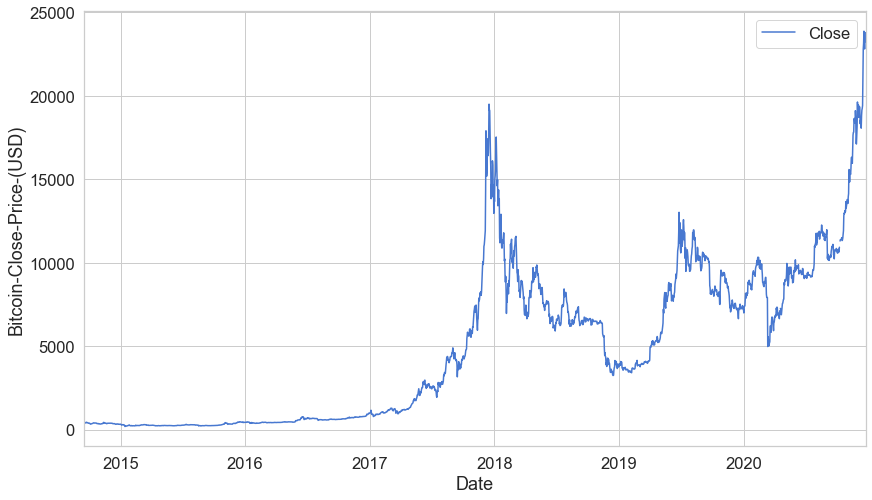

In [8]:
ax = Data.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Bitcoin-Close-Price-(USD)")

## Normalizing Data

Bringing the data in the range [0,1], this will help our optimization algorithm converge faster.

In [9]:
scaler = MinMaxScaler()

close_price = Data.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [10]:
scaled_close.shape

(2291, 1)

In [11]:
np.isnan(scaled_close).any()

True

In [12]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

Removing nan values

In [13]:
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
np.isnan(scaled_close).any()

False

## Data Preprocessing

Input of LSTM requires a 3 dimensions data. The shape required is
[batch_size, sequence_length, n_features]

In [15]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])
    print(num_train)

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

2077


In [22]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2077, 99, 1) (2077, 1) (110, 99, 1) (110, 1)


In [23]:
print(X_train.shape[-1])

1


## LSTM Model

In [17]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))

## Training LSTM

In [18]:
BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

with tf.device('gpu'):
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_split=0.1
    )

Epoch 1/50
30/30 [==============================] - 8s 119ms/step - loss: 0.0036 - val_loss: 0.0074
Epoch 2/50
30/30 [==============================] - 2s 67ms/step - loss: 0.0341 - val_loss: 0.0163
Epoch 3/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0099 - val_loss: 9.9464e-04
Epoch 4/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 5/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0168 - val_loss: 0.0019
Epoch 6/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 7/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0041 - val_loss: 9.5753e-04
Epoch 8/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0046 - val_loss: 8.6273e-04
Epoch 9/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0050 - val_loss: 7.6776e-04
Epoch 10/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0052 - val_loss:

In [19]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 33ms/step - loss: 0.0010


0.0010401926701888442

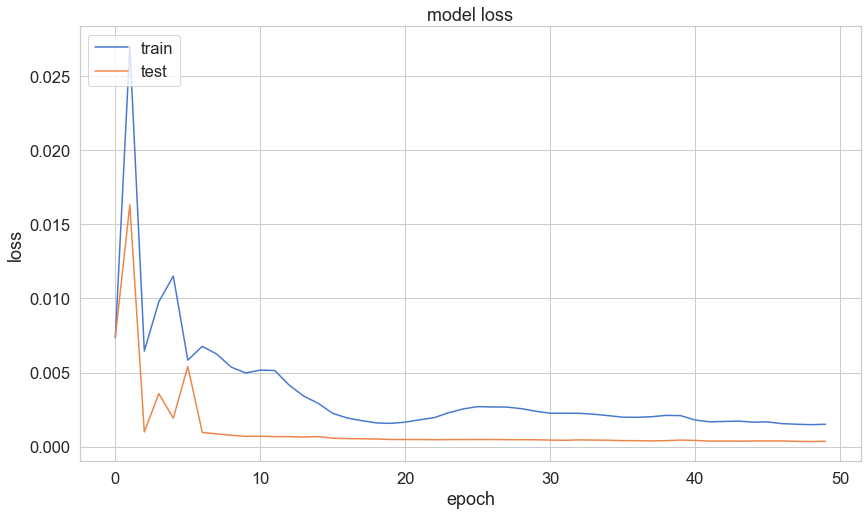

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

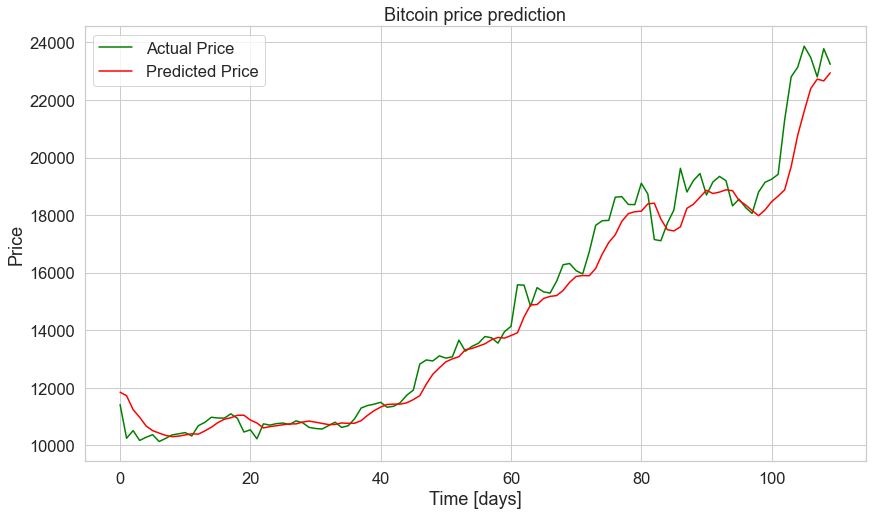

In [21]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();